In [77]:
import pandas as pd
import seaborn as sns

from pandas import DataFrame

In [78]:
train_store = pd.read_pickle("../data/1_train_store_preprocessed.pkl")\
    .sort_values(['Store','Date'])
train_store = train_store[train_store.DayOfWeek < 7]

test_store = pd.read_pickle("../data/1_test_store_preprocessed.pkl")\
    .sort_values(['Store','Date'])
test_store = test_store[test_store.DayOfWeek < 7]

In [79]:
# Utilizo las mismas tiendas que busco predecir
train_store = train_store[train_store.Store.isin(test_store.Store.unique())]

In [80]:
# Coeficiente de Variacion
cv_data = train_store\
    .groupby('Store')\
    .agg(
        average=('Sales','mean'),
        sd=('Sales','std')
    )\
    .reset_index()


cv_data['cv_sqr'] = (cv_data['sd']/cv_data['average'])**2
cv_data

,Store,average,sd,cv_sqr
0,1,4600.066832,1312.455160,0.081403
1,3,6693.392327,2511.563403,0.140798
2,7,8576.982673,2809.607516,0.107306
3,8,5374.823020,2089.579967,0.151144
4,9,6326.808168,2012.259979,0.101158
...,...,...,...,...
851,1111,5063.212871,1906.980624,0.141854
852,1112,9869.175743,3788.467487,0.147355
853,1113,6430.992574,1823.702855,0.080418
854,1114,20052.704208,4888.044210,0.059419


In [81]:
# Average Demand Interval

df_adi = train_store[train_store.Sales > 0]
df_adi['Previous_Sale_Date'] = train_store.groupby('Store').Date.shift()

intervals = df_adi.Date - df_adi.Previous_Sale_Date
df_adi['Interval'] = intervals.astype(str).str.replace('days','')
df_adi['Interval'] = pd.to_numeric(df_adi.Interval, errors='coerce')

ADI = df_adi.groupby('Store').agg(ADI = ('Interval','mean')).reset_index()
ADI

/var/folders/nj/1348lmsd03181pj1pqgz48_w0000gp/T/ipykernel_17300/1992771824.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adi['Previous_Sale_Date'] = train_store.groupby('Store').Date.shift()
/var/folders/nj/1348lmsd03181pj1pqgz48_w0000gp/T/ipykernel_17300/1992771824.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adi['Interval'] = intervals.astype(str).str.replace('days','')
/var/folders/nj/1348lmsd03181pj1pqgz48_w0000gp/T/ipykernel_17300/1992771824.py:8: SettingWithCopyWarning: 
A value is

,Store,ADI
0,1,1.163892
1,3,1.164313
2,7,1.162850
3,8,1.163265
4,9,1.164313
...,...,...
851,1111,1.164313
852,1112,1.164313
853,1113,1.163265
854,1114,1.163265


In [82]:
adi_cv = pd.merge(ADI,cv_data)
adi_cv

,Store,ADI,average,sd,cv_sqr
0,1,1.163892,4600.066832,1312.455160,0.081403
1,3,1.164313,6693.392327,2511.563403,0.140798
2,7,1.162850,8576.982673,2809.607516,0.107306
3,8,1.163265,5374.823020,2089.579967,0.151144
4,9,1.164313,6326.808168,2012.259979,0.101158
...,...,...,...,...,...
851,1111,1.164313,5063.212871,1906.980624,0.141854
852,1112,1.164313,9869.175743,3788.467487,0.147355
853,1113,1.163265,6430.992574,1823.702855,0.080418
854,1114,1.163265,20052.704208,4888.044210,0.059419


In [83]:
## Defining a fuction for categorization
## source https://frepple.com/blog/demand-classification/

def category(df: DataFrame):
    a=0

    if (df['ADI'] < 1.32) & (df['cv_sqr'] < 0.49):
        a='Smooth'
    if (df['ADI'] >= 1.32) & (df['cv_sqr'] >= 0.49):
        a='Lumpy'
    if (df['ADI'] < 1.32) & (df['cv_sqr'] >= 0.49):
        a='Erratic'
    if (df['ADI'] >= 1.32) & (df['cv_sqr'] < 0.49):
        a='Intermittent'
    return a

In [84]:
## Categorizing products based on their forcastability

adi_cv['category'] = adi_cv.apply(category ,axis=1)
adi_cv

,Store,ADI,average,sd,cv_sqr,category
0,1,1.163892,4600.066832,1312.455160,0.081403,Smooth
1,3,1.164313,6693.392327,2511.563403,0.140798,Smooth
2,7,1.162850,8576.982673,2809.607516,0.107306,Smooth
3,8,1.163265,5374.823020,2089.579967,0.151144,Smooth
4,9,1.164313,6326.808168,2012.259979,0.101158,Smooth
...,...,...,...,...,...,...
851,1111,1.164313,5063.212871,1906.980624,0.141854,Smooth
852,1112,1.164313,9869.175743,3788.467487,0.147355,Smooth
853,1113,1.163265,6430.992574,1823.702855,0.080418,Smooth
854,1114,1.163265,20052.704208,4888.044210,0.059419,Smooth


<AxesSubplot:xlabel='cv_sqr', ylabel='ADI'>

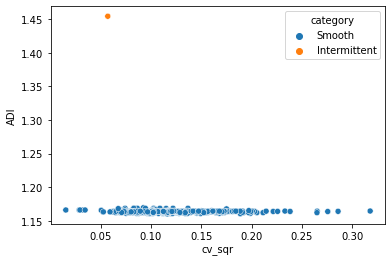

In [85]:
## Visualizing the categories

sns.scatterplot(
    x='cv_sqr',
    y='ADI'
    ,hue='category',
    data=adi_cv
)

In [86]:
## Final category counts
adi_cv.category.value_counts()

Smooth          855
Intermittent      1
Name: category, dtype: int64

In [87]:
adi_cv[adi_cv.category == 'Intermittent']

,Store,ADI,average,sd,cv_sqr,category
392,512,1.454545,5285.050769,1263.751422,0.057177,Intermittent
